# DEA Data Preparation
**Traprock KBA, QLD - Change Detection Jul 2015 to Jul 2023**

Author: Michael Dear, May 2024

This notebook is based on the following DEA notebooks:
* [Parallel Processing With Dask Beginner's Guide](https://knowledge.dea.ga.gov.au/notebooks/Beginners_guide/09_Parallel_processing_with_Dask/)
* [Calculating Band Indices How-to](https://knowledge.dea.ga.gov.au/notebooks/How_to_guides/Calculating_band_indices/)
* [Generating Composite Images How-to](https://knowledge.dea.ga.gov.au/notebooks/How_to_guides/Generating_composites/)
* [Extract and Analyse Data for Multiple Polygons](https://knowledge.dea.ga.gov.au/notebooks/How_to_guides/Analyse_multiple_polygons/)


## Setup

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
import numpy as np
import geopandas as gpd

from datacube.drivers.netcdf import write_dataset_to_netcdf

import sys
sys.path.insert(1, '../../Tools/')

from dea_tools.plotting import rgb, display_map
from dea_tools.datahandling import load_ard
from dea_tools.dask import create_local_dask_cluster
from dea_tools.bandindices import calculate_indices

# For masking using a polygon
from shapely.geometry import mapping

# Turn off warnings 
import warnings
warnings.filterwarnings('ignore')

### Connect to the datacube
The next step is to connect to the datacube database.
The resulting `dc` datacube object can then be used to load data.
The `app` parameter is a unique name used to identify the notebook that does not have any effect on the analysis.

In [2]:
dc = datacube.Datacube(app="Create_dataset")

### Global Parameters
* Global parameters are used in multiple places
* Local parameters should be found above the relevant code

In [3]:
from global_params import *

## Create Dask Client

In [4]:
# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/mjdear68@gmail.com/proxy/8787/status,
Dashboard: /user/mjdear68@gmail.com/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37819,Workers: 1
Dashboard: /user/mjdear68@gmail.com/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:40647,Total threads: 2
Dashboard: /user/mjdear68@gmail.com/proxy/41425/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:46743,


## Step 1: Load the study area polygon

In [5]:
# Load the polygon
poly = gpd.read_file(vector_dir+study_area_abbrev+'.geojson')

In [6]:
poly.head()

,name,description,timestamp,begin,end,altitudemode,tessellate,extrude,visibility,draworder,icon,snippet,geometry
0,Traprock,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",NaN,NaN,NaN,clampToGround,-1,0,-1,NaN,NaN,,"MULTIPOLYGON Z (((151.54253 -28.28821 0.00000,..."


In [7]:
# Set the CRS to EPSG:4326
poly = poly.to_crs(4326)

<Axes: >

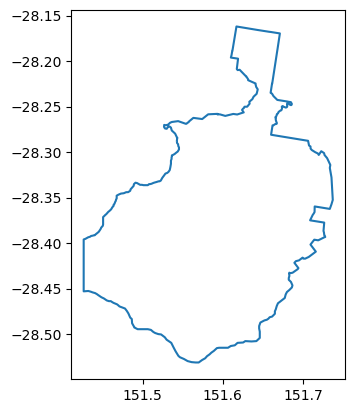

In [8]:
# Plot to check
poly.boundary.plot()

In [9]:
# Get the coordinates of the bounding box
bounds = poly.total_bounds
bounds

array([151.42622653, -28.5312104 , 151.73728125, -28.16195009])

In [10]:
# Set the latitude and longitude
study_area_lat = (bounds[1], bounds[3])
study_area_lon = (bounds[0], bounds[2])

### Display the data on a map

In [11]:
display_map(x=study_area_lon, y=study_area_lat)

## Step 2: Select Dates
Use the [DEA Maps](https://maps.dea.ga.gov.au/#share=s-02TACjEp7EBe0FBXTOYPXvGts7f) to select cloud-free or well-masked mostly cloud-free dates. The dates should be as close to the same time of year as possible.

*Note*: For Landsat, *take one off* the days displayed in the DEA map.

In [43]:
periods = {
           'Jul 2015':['2015-07-29'],
           'Jul 2023':['2023-07-19']
          }

In [44]:
# This parameter sets the number of dates at the end of each period to use to create the bi-temporal change detection pair. 
num_targ_dates = 1

## Step 3: Extract Data

### Create a Dask chunk size array
This will adjust automatically depending on the bounding box of the study area.

See https://gis.stackexchange.com/questions/142326/calculating-longitude-length-in-miles for converting longitude to metres.

In [56]:
# Approximate pixel dimensions of the study area in the desired spatial resolution.
# Used for setting the dask chunk dimensions.
dask_chunk_size = []
dask_chunk_prop = 0.5 # Use this to set the proportion of the x, y dimensions to set as Dask chunk sizes

# x length
dask_chunk_size.append(
    (np.abs((study_area_lon[1] - study_area_lon[0])*111111
         # *np.cos(study_area_lat[1]/(2*np.pi)) # This is incorrect; not necessary to have this level of accuracy
         /spatial_res
         *dask_chunk_prop)
         .round()
))

# y length
dask_chunk_size.append(
    (np.abs((study_area_lat[1] - study_area_lat[0])*111111
         /spatial_res
         *dask_chunk_prop)
         .round()
)
)

# Dask will not accept numpy integers. Need to convert to regular integers.
dask_chunk_size = [int(i) for i in dask_chunk_size]
for i in dask_chunk_size:
    print(i, type(i))

576 <class 'int'>
684 <class 'int'>


#### Function to extract data for a given date

In [57]:
def get_data(date): 
    '''
    Function to load data for a given date
    '''
    ds = load_ard(dc=dc,
              # Landsat
              products = ['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3', 'ga_ls9c_ard_3'], 
              measurements = ["nbart_red", "nbart_blue", "nbart_green", "nbart_nir", "nbart_swir_1", "nbart_swir_2"],
              # # Sentinel 2 
              # products = ['ga_s2am_ard_3', 'ga_s2bm_ard_3'], 
              # measurements = ["nbart_red", "nbart_blue", "nbart_green", "nbart_nir_1", "nbart_swir_2"],
              x=study_area_lon,
              y=study_area_lat,
              time=(date),
              output_crs='EPSG:3577', # 3308 NSW Lambert; 3577 Australian Albers; 4326 does not work - not sure why
              resolution=(-spatial_res, spatial_res),
              group_by='solar_day',
              dask_chunks={"time": 1, "x": dask_chunk_size[0] , "y": dask_chunk_size[1]}, # uncomment if using dask
              # cloud_mask='s2cloudless' # Uncomment if using Sentinel data
             )
    return ds

In [58]:
ds_base = ([xr.concat([get_data(date) for date in dates], dim='time')
           # .mean(dim='time') 
           # .assign_coords({'period':name})
           for name, dates in periods.items()] 
         )
ds_base = xr.concat(ds_base, dim='time')

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
    ga_ls9c_ard_3
Applying fmask pixel quality/cloud mask
Returning 1 time steps as a dask array
Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
    ga_ls9c_ard_3
Applying fmask pixel quality/cloud mask
Returning 1 time steps as a dask array


### Create Indices
*Note*: This function will create a dataset with all the original variables and the new variable(s).

#### Collections
* For Landsat (i.e. GA Landsat Collection 3), specify collection='ga_ls_3'.
* For Sentinel 2 (i.e. GA Sentinel 2 Collection 3), specify collection='ga_s2_3'

In [59]:
ds_base = calculate_indices(ds_base, index=['NDVI','NBR'], collection='ga_ls_3') 
ds_base

<xarray.Dataset> Size: 117MB
Dimensions:       (time: 2, y: 1518, x: 1204)
Coordinates:
  * time          (time) datetime64[ns] 16B 2015-07-29T23:47:55.046637 2023-0...
  * y             (y) float64 12kB -3.2e+06 -3.2e+06 ... -3.246e+06 -3.246e+06
  * x             (x) float64 10kB 1.871e+06 1.871e+06 ... 1.907e+06 1.907e+06
    spatial_ref   int32 4B 3577
Data variables:
    nbart_red     (time, y, x) float32 15MB dask.array<chunksize=(1, 684, 576), meta=np.ndarray>
    nbart_blue    (time, y, x) float32 15MB dask.array<chunksize=(1, 684, 576), meta=np.ndarray>
    nbart_green   (time, y, x) float32 15MB dask.array<chunksize=(1, 684, 576), meta=np.ndarray>
    nbart_nir     (time, y, x) float32 15MB dask.array<chunksize=(1, 684, 576), meta=np.ndarray>
    nbart_swir_1  (time, y, x) float32 15MB dask.array<chunksize=(1, 684, 576), meta=np.ndarray>
    nbart_swir_2  (time, y, x) float32 15MB dask.array<chunksize=(1, 684, 576), meta=np.ndarray>
    NDVI          (time, y, x) float32 15MB dask.array<chunksize=(1, 684, 576), meta=np.ndarray>
    NBR           (time, y, x) float32 15MB dask.array<chunksize=(1, 684, 576), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Create the final dataset

#### Add the period dimension

In [67]:
final = ([ds_base.sel(time = dates[-num_targ_dates])
           .mean(dim='time') 
           .assign_coords({'period':period})
           for period, dates in periods.items()] 
         )

ds_final = xr.concat(final, dim='period')

ds_final

<xarray.Dataset> Size: 117MB
Dimensions:       (period: 2, y: 1518, x: 1204)
Coordinates:
  * y             (y) float64 12kB -3.2e+06 -3.2e+06 ... -3.246e+06 -3.246e+06
  * x             (x) float64 10kB 1.871e+06 1.871e+06 ... 1.907e+06 1.907e+06
    spatial_ref   int32 4B 3577
  * period        (period) <U8 64B 'Jul 2015' 'Jul 2023'
Data variables:
    nbart_red     (period, y, x) float32 15MB dask.array<chunksize=(1, 684, 576), meta=np.ndarray>
    nbart_blue    (period, y, x) float32 15MB dask.array<chunksize=(1, 684, 576), meta=np.ndarray>
    nbart_green   (period, y, x) float32 15MB dask.array<chunksize=(1, 684, 576), meta=np.ndarray>
    nbart_nir     (period, y, x) float32 15MB dask.array<chunksize=(1, 684, 576), meta=np.ndarray>
    nbart_swir_1  (period, y, x) float32 15MB dask.array<chunksize=(1, 684, 576), meta=np.ndarray>
    nbart_swir_2  (period, y, x) float32 15MB dask.array<chunksize=(1, 684, 576), meta=np.ndarray>
    NDVI          (period, y, x) float32 15MB dask.array<chunksize=(1, 684, 576), meta=np.ndarray>
    NBR           (period, y, x) float32 15MB dask.array<chunksize=(1, 684, 576), meta=np.ndarray>

#### Add the mean and SD of the indices to the final dataset

In [61]:
var_dict = {'NDVI':'NDVI_mean', 'NBR':'NBR_mean'}

In [62]:
ds_mean = ([ds_base[list(var_dict.keys())]
           .sel(time=slice(dates[0], dates[-num_targ_dates]))
           .mean(dim='time') 
           .assign_coords({'period':period})
           for period, dates in periods.items()] 
         )

ds_mean = xr.concat(ds_mean, dim='period')

In [63]:
ds_mean = ds_mean.rename({'NDVI':'NDVI_mean', 'NBR':'NBR_mean'})

In [64]:
ds_std = ([ds_base[list(var_dict.keys())]
           .sel(time=slice(dates[0], dates[-num_targ_dates]))
           .std(dim='time') 
           .assign_coords({'period':period})
           for period, dates in periods.items()] 
         )

ds_std = xr.concat(ds_std, dim='period')

In [65]:
ds_std = ds_std.rename({'NDVI':'NDVI_sd', 'NBR':'NBR_sd'})

In [66]:
ds_final = ds_final.merge(ds_mean).merge(ds_std)

#### Re-order the variables

In [46]:
final_vars = [
    'nbart_red',
    'nbart_green',
    'nbart_blue',
    'nbart_nir',
    'nbart_swir_1',
    'nbart_swir_2',
    'NDVI',
    'NDVI_mean',
    'NDVI_sd',
    'NBR',
    'NBR_mean',
    'NBR_sd'
]

In [47]:
ds_final = ds_final[final_vars]
ds_final

<xarray.Dataset> Size: 175MB
Dimensions:       (period: 2, y: 1518, x: 1204)
Coordinates:
  * y             (y) float64 12kB -3.2e+06 -3.2e+06 ... -3.246e+06 -3.246e+06
  * x             (x) float64 10kB 1.871e+06 1.871e+06 ... 1.907e+06 1.907e+06
    spatial_ref   int32 4B 3577
  * period        (period) <U8 64B 'Jul 2015' 'Jul 2023'
Data variables:
    nbart_red     (period, y, x) float32 15MB 532.0 447.0 442.0 ... 381.0 351.0
    nbart_green   (period, y, x) float32 15MB 470.0 410.0 417.0 ... 336.0 297.0
    nbart_blue    (period, y, x) float32 15MB 328.0 286.0 302.0 ... 180.0 175.0
    nbart_nir     (period, y, x) float32 15MB 2.131e+03 1.838e+03 ... 1.326e+03
    nbart_swir_1  (period, y, x) float32 15MB 1.773e+03 1.467e+03 ... 1.475e+03
    nbart_swir_2  (period, y, x) float32 15MB 998.0 821.0 820.0 ... 925.0 893.0
    NDVI          (period, y, x) float32 15MB 0.6005 0.6088 ... 0.5804 0.5814
    NDVI_mean     (period, y, x) float32 15MB dask.array<chunksize=(1, 684, 98), meta=np.ndarray>
    NDVI_sd       (period, y, x) float32 15MB dask.array<chunksize=(1, 684, 98), meta=np.ndarray>
    NBR           (period, y, x) float32 15MB 0.3621 0.3825 ... 0.2161 0.1951
    NBR_mean      (period, y, x) float32 15MB dask.array<chunksize=(1, 684, 98), meta=np.ndarray>
    NBR_sd        (period, y, x) float32 15MB dask.array<chunksize=(1, 684, 98), meta=np.ndarray>

### Check the dataset size

In [68]:
# Check the dataset size
print('Dataset size = ', np.round(ds_final.nbytes/1024**3,3), 'Gb')

Dataset size =  0.109 Gb


### Load the dataset into memory
Loading the data can take a long time depending on the size of the study area and the duration of the study. Clicking the Dashboard link in the output from loading Dask at the beginning of the notebook will open a page showing the progress of the task.

Here are some ways to decrease the load time:
* Optimize the chunk size. This means experimenting with increasing or decreasing the number of `x` and `y` pixels in the `dask_chunks` parameter of the `load_ard` function. 1024 and 2048 are good places to start, but it depends on the size of your x and y dimensions. Leave `"time" : 1`.
* Reduce the spatial resolution in the `load_ard` function.
* Reduce the number of `products` in the `load_ard` function e.g. choose Sentinel 2A or Sentinel 2B  rather than both.
* Reduce the period in the `load_ard` function by changing the `time` parameter.
* Try a different time of day e.g. after work hours. 

In [69]:
%%time
ds = ds_final.load()

CPU times: user 1.03 s, sys: 190 ms, total: 1.22 s
Wall time: 19.3 s


### Close the Dask client if it is no longer required

In [70]:
client.close()

### Check for missing data
These are some options for removing missing data. There should be no missing data for the analysis steps.

* Go back and add another clear date close to the target date; make a mean composite from these two dates.
* Apply `interpolate_na()` if there are only a small number of missing values.

In [71]:
for period in ds.period:
    print(ds.nbart_red.sel(period=period).isnull().sum())

<xarray.DataArray 'nbart_red' ()> Size: 8B
array(0)
Coordinates:
    spatial_ref  int32 4B 3577
    period       <U8 32B 'Jul 2015'
<xarray.DataArray 'nbart_red' ()> Size: 8B
array(108)
Coordinates:
    spatial_ref  int32 4B 3577
    period       <U8 32B 'Jul 2023'


In [72]:
ds = ds.interpolate_na(dim='x')

In [74]:
for period in ds.period:
    print(ds.nbart_red.sel(period=period).isnull().sum())

<xarray.DataArray 'nbart_red' ()> Size: 8B
array(0)
Coordinates:
    spatial_ref  int32 4B 3577
    period       <U8 32B 'Jul 2015'
<xarray.DataArray 'nbart_red' ()> Size: 8B
array(0)
Coordinates:
    spatial_ref  int32 4B 3577
    period       <U8 32B 'Jul 2023'


### Plot to check data

After loading the data, it is useful to view it to understand the resolution, which observations are impacted by cloud cover, and whether there are any obvious differences between time steps.

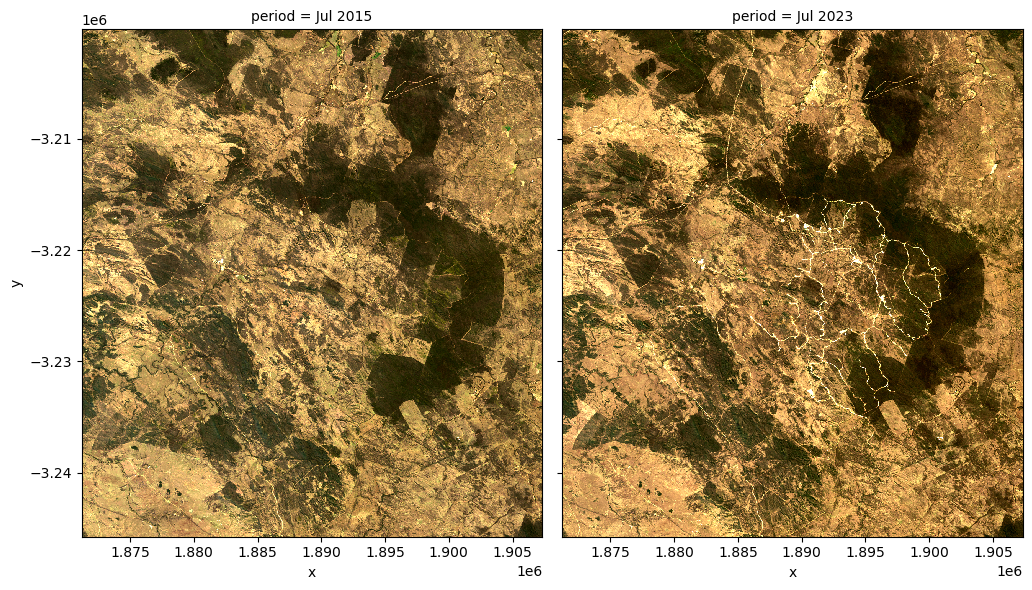

In [75]:
# RGB plot
rgb(ds, 
    bands=['nbart_red', 'nbart_green', 'nbart_blue'], 
    col='period')

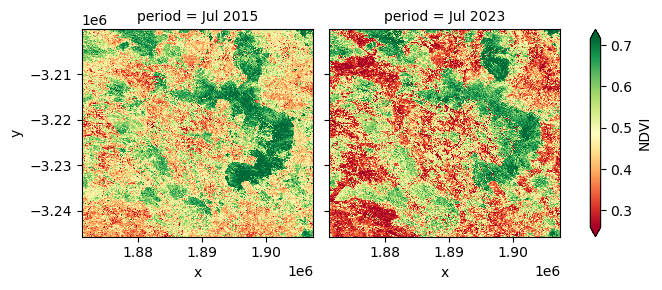

In [22]:
# NDVI_mean plot
ds['NDVI_mean'].plot(col='period', cmap='RdYlGn', robust=True)

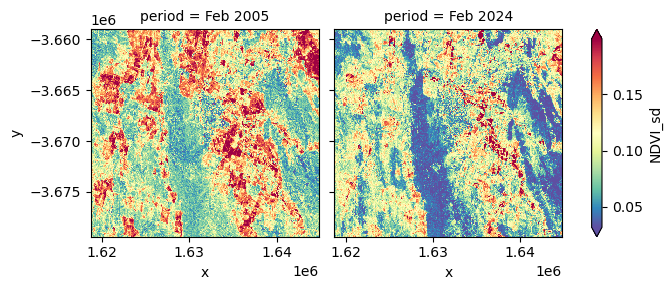

In [31]:
# NDVI_sd plot
ds['NDVI_sd'].plot(col='period', cmap='Spectral_r', robust=True)

## Step 4: Create a mask

In [23]:
# Copy the first variable in the dataset to use as the basis for the mask
# mask = ds[list(ds.data_vars.keys())[0]].isel(year=0)
mask = xr.DataArray(
            data = np.ones((ds.sizes['y'], ds.sizes['x'])),
            dims = {'y':ds.dims['y'], 'x':ds.dims['x']},
            coords = {'y':ds['y'], 'x':ds['x'],},
            attrs = ds.attrs
)

mask.name = 'mask'

# Make sure the mask and polygon have the same crs
poly = poly.to_crs(crs)
mask = mask.rio.write_crs(crs)

# Clip the mask using the polygon
mask = mask.rio.clip(poly.geometry.apply(mapping), poly.crs, drop=False)

# Set all masked values to nan and all non-masked values to 1
mask = mask.where(mask != -999, np.nan)
mask = mask.where(mask.isnull(), 1)

mask

<xarray.DataArray 'mask' (y: 1518, x: 1204)> Size: 15MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y            (y) float64 12kB -3.2e+06 -3.2e+06 ... -3.246e+06 -3.246e+06
  * x            (x) float64 10kB 1.871e+06 1.871e+06 ... 1.907e+06 1.907e+06
    spatial_ref  int64 8B 0

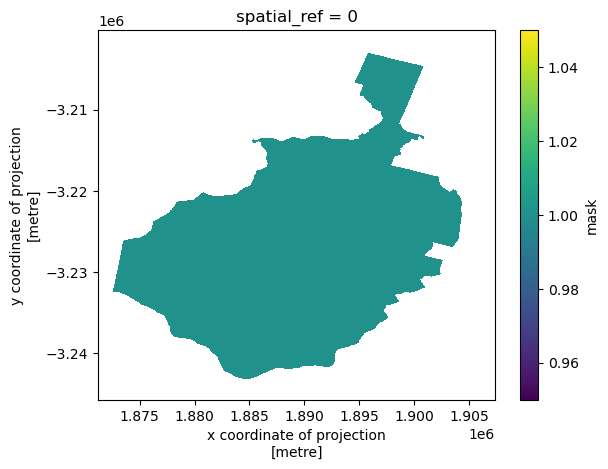

In [24]:
# Test plot
mask.plot()

## Step 5: Export data

### netCDF

In [25]:
# Remove CRS info because it prevents file saving
# ds.period.attrs=[]

# Save as netCDF
ds.to_netcdf(netcdf_dir+study_area_abbrev+'.nc')

In [26]:
# Save mask data array
mask.to_netcdf(netcdf_dir+'mask.nc')